In [2]:
import numpy as np
import matplotlib.pyplot as plt

from jlinops import _CustomLinearOperator
import jlinops

# Solve the unweighted dirichlet laplacian using neumann laplacian as preconditioner

In [3]:
from jlinops import Dirichlet2DSym, Neumann2D
from scipy.sparse.linalg import cg as sp_cg
import math

In [4]:
from jlinops import dct_sqrt, dct_sqrt_pinv, MatrixLinearOperator, IdentityOperator, QRPinvOperator, dct_get_eigvals

In [5]:
class CGDirichlet2DSymLapInvOperator(_CustomLinearOperator):

    def __init__(self, grid_shape, check=True, *args, **kwargs):

        # Make both operators
        self.grid_shape = grid_shape
        self.n = math.prod(grid_shape)
        self.Rd = Dirichlet2DSym(grid_shape)
        self.Rn = Neumann2D(grid_shape) 

        # Misc
        self.check = check

        # Build Dirichlet Laplacian
        self.A = self.Rd.T @ self.Rd
        self.M = self.Rn.T @ self.Rn

        # Matrix spanning the kernel of the Neumann operator
        self.Wmat = np.ones((self.n,1))
        self.W = MatrixLinearOperator(self.Wmat)

        # Operator for getting the part of solution in the kernel
        self.sol_ker_op = self.W @ ( MatrixLinearOperator( np.linalg.inv( self.Wmat.T @ ( self.Rd.rmatmat(self.Rd.matmat(self.Wmat)) )  ) ) @ self.W.T )
        #self.sol_ker_op = self.W @ (  ( 1.0 / ( self.Wmat.T @ ( self.A @ self.Wmat )  ) )  @ self.W.T )

        # Get L, Lpseudo, and Loblique
        self.L = dct_sqrt(self.M, self.grid_shape).T
        self.Lpinv = dct_sqrt_pinv(self.M, self.grid_shape).T
        print("Starting QRpinv")
        self.RdWpinv = QRPinvOperator(self.Rd @ self.Wmat)
        print("Finished QRpinv")
        self.Loblique = ( IdentityOperator( (self.n,self.n) ) - (self.W @ self.RdWpinv @ self.Rd) ) @ self.Lpinv
 
        # Set of coefficient matrix
        print("Setting up C")
        self.C = self.Loblique.T @ self.A @ self.Loblique
        print("Finished C")

        def _matvec(x):

            sol, converged = sp_cg( self.C, self.Loblique.T @ x, x0=None, M=None, *args, **kwargs) 
            if self.check:
                assert converged == 0, "CG algorithm did not converge!"
            
            # Project onto range of L
            sol = self.L @ self.Lpinv @ sol
            
            part_one = self.Loblique @ sol
            part_two = self.sol_ker_op @ x

            result = part_one + part_two

            return result

        super().__init__( (self.n, self.n), _matvec, _matvec, dtype=np.float64, device="cpu")

In [6]:
grid_shape = (6,4)
Q = CGDirichlet2DSymLapInvOperator(grid_shape, tol=1e-9)

Starting QRpinv
Finished QRpinv
Setting up C
Finished C


In [22]:
grid_shape = (400, 400)
Q = CGDirichlet2DSymLapInvOperator(grid_shape, tol=1e-5)

Starting QRpinv
Finished QRpinv
Setting up C
Finished C


In [23]:
randvec = np.random.normal(size=Q.shape[1])
tmp = Q @ randvec
tmp2 = Q.A @ tmp
print(np.linalg.norm(randvec - tmp2))

0.0013432822844264018


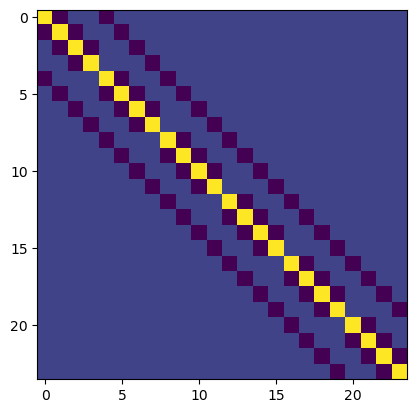

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Q.A))
plt.show()

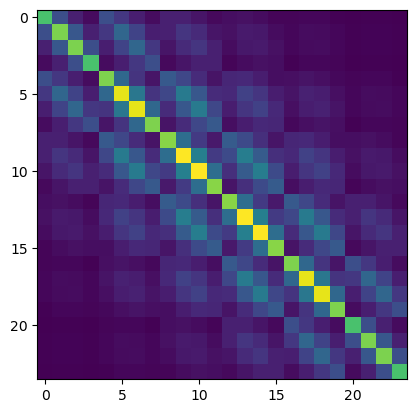

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Q))
plt.show()

In [ ]:
Amat = jlinops.black_box_to_dense(Q.A)
Qnp = np.linalg.inv(Amat)

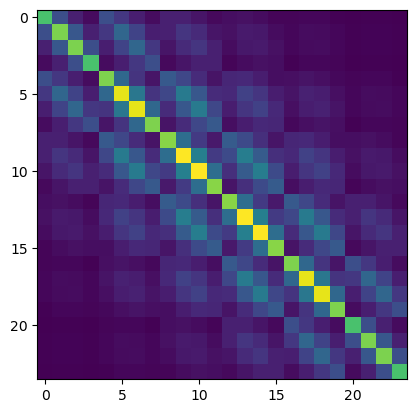

In [ ]:
plt.imshow(Qnp)
plt.show()

# Weighted version

In [ ]:
from jlinops import DiagonalOperator

In [ ]:
class CGWeightedDirichlet2DSymLapInvOperator(_CustomLinearOperator):

    def __init__(self, grid_shape, weights, check=True, *args, **kwargs):

        # Make both operators
        self.grid_shape = grid_shape
        self.Rn = Neumann2D(grid_shape)
        self.n = self.Rn.shape[1] 
        self.Rd = DiagonalOperator(np.sqrt(weights)) @ Dirichlet2DSym(grid_shape)
        self.weights = weights

        # Misc
        self.check = check

        # Build Dirichlet Laplacian
        self.A = self.Rd.T @ self.Rd
        self.M = self.Rn.T @ self.Rn

        # Matrix spanning the kernel of the Neumann operator
        self.Wmat = np.ones((self.n, 1))
        self.W = MatrixLinearOperator(self.Wmat)

        # Operator for getting the part of solution in the kernel
        self.sol_ker_op = self.Wmat @ np.linalg.inv( self.Wmat.T @ ( self.A @ self.Wmat )  ) @ self.Wmat.T

        # Get L, Lpseudo, and Loblique
        self.L = dct_sqrt(self.M, self.grid_shape).T
        self.Lpinv = dct_sqrt_pinv(self.M, self.grid_shape).T
        self.RdWpinv = QRPinvOperator(self.Rd @ self.Wmat)
        self.Loblique = ( IdentityOperator( (self.n,self.n) ) - (self.W @ self.RdWpinv @ self.Rd) ) @ self.Lpinv
 
        # Set of coefficient matrix
        self.C = self.Loblique.T @ self.A @ self.Loblique


        def _matvec(x):

            sol, converged = sp_cg( self.C, self.Loblique.T @ x, x0=None, M=None, *args, **kwargs) 
            if self.check:
                assert converged == 0, "CG algorithm did not converge!"
            
            # Project onto range of L
            sol = self.L @ self.Lpinv @ sol
            
            part_one = self.Loblique @ sol
            part_two = self.sol_ker_op @ x

            result = part_one + part_two

            return result


        super().__init__( (self.n, self.n), _matvec, _matvec, dtype=np.float64, device="cpu")

In [ ]:
grid_shape = (6,4)
np.random.seed(0)
_R = jlinops.Dirichlet2DSym(grid_shape)
weights = np.random.uniform(low=1, high=100, size=_R.shape[0])
Q = CGWeightedDirichlet2DSymLapInvOperator(grid_shape, weights, tol=1e-9)

In [ ]:
randvec = np.random.normal(size=Q.shape[1])
tmp = Q @ randvec
tmp2 = Q.A @ tmp
print(np.linalg.norm(randvec - tmp2))

1.7214016814087274e-09


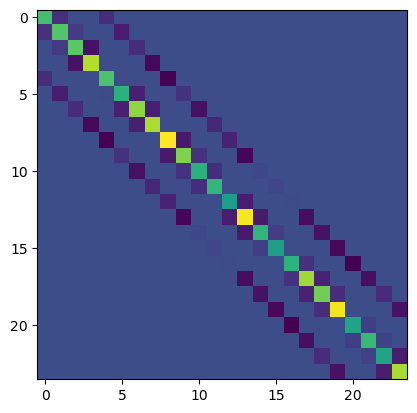

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Q.A))
plt.show()

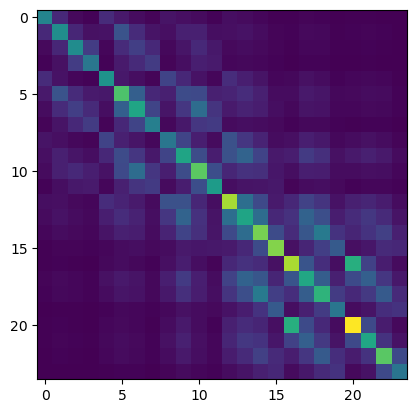

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Q))
plt.show()

In [ ]:
Amat = jlinops.black_box_to_dense(Q.A)
Qnp = np.linalg.inv(Amat)

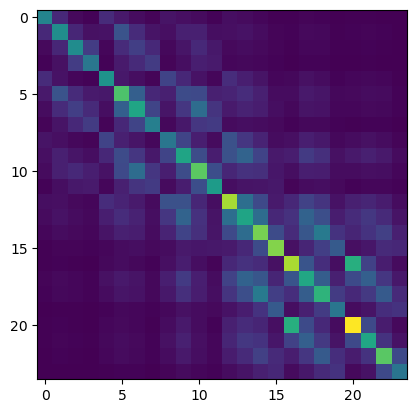

In [ ]:
plt.imshow(Qnp)
plt.show()

# Pseudoinverses?

## Unweighted

In [ ]:
class CGDirichlet2DSymPinvOperator(_CustomLinearOperator):

    def __init__(self, grid_shape, check=True, *args, **kwargs):

        # Make operator
        self.R = Dirichlet2DSym(grid_shape)
        m, n = self.R.shape

        # Make Laplacian solver
        self.inv_lap = CGDirichlet2DSymLapInvOperator(grid_shape=grid_shape, check=check, *args, **kwargs)

        def _matvec(x):

            tmp = self.R.rmatvec(x)
            result = self.inv_lap.matvec(tmp)

            return result
        

        def _rmatvec(x):

            tmp = self.inv_lap.matvec(x)
            result = self.R.matvec(tmp)

            return result
        

        super().__init__( (n, m), _matvec, _rmatvec, dtype=np.float64, device="cpu")

In [ ]:
grid_shape = (6,4)
np.random.seed(0)
R = jlinops.Dirichlet2DSym(grid_shape)
Rpinv = CGDirichlet2DSymPinvOperator(grid_shape, tol=1e-9)

In [ ]:
Rpinv @ np.random.normal(size=Rpinv.shape[1])

array([-0.35246567, -0.0421227 , -0.5000938 ,  0.1691421 ,  0.02730022,
       -0.01652612, -0.89239238, -0.00322362,  0.62035099,  0.32230836,
       -0.63136999,  0.32691975,  0.03411329, -0.23607429, -0.33593552,
       -0.87889749, -0.41210703, -0.238647  , -1.03472503, -0.96730257,
       -0.75324846, -0.4769137 ,  0.03735114, -0.80822576])

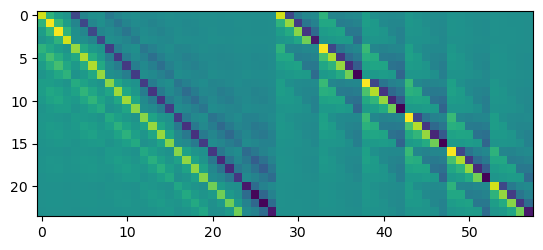

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Rpinv))
plt.show()

In [ ]:
Rmat = jlinops.black_box_to_dense(R)
Rpinv_mat = np.linalg.pinv(Rmat)

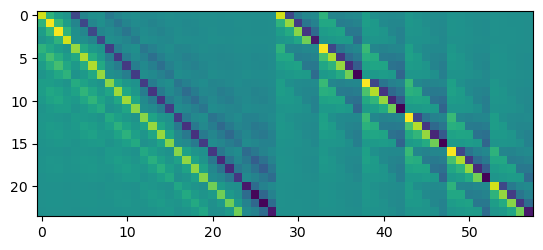

In [ ]:
plt.imshow(Rpinv_mat)
plt.show()

## Weighted

In [ ]:
from jlinops import DiagonalOperator

In [ ]:
class CGWeightedDirichlet2DSymPinvOperator(_CustomLinearOperator):

    def __init__(self, grid_shape, weights, check=True, *args, **kwargs):

        # Make operator
        self.R = DiagonalOperator(np.sqrt(weights)) @ Dirichlet2DSym(grid_shape)
        self.weights = weights
        m, n = self.R.shape

        # Make Laplacian solver
        self.inv_lap = CGWeightedDirichlet2DSymLapInvOperator(grid_shape=grid_shape, weights=weights, check=check, *args, **kwargs)

        def _matvec(x):

            tmp = self.R.rmatvec(x)
            result = self.inv_lap.matvec(tmp)

            return result
        

        def _rmatvec(x):

            tmp = self.inv_lap.matvec(x)
            result = self.R.matvec(tmp)

            return result
        

        super().__init__( (n, m), _matvec, _rmatvec, dtype=np.float64, device="cpu")

In [ ]:
grid_shape = (200,200)
np.random.seed(0)
_R = jlinops.Dirichlet2DSym(grid_shape)
weights = np.random.uniform(low=1, high=100, size=_R.shape[0])
R = DiagonalOperator(np.sqrt(weights)) @ _R
Rpinv = CGWeightedDirichlet2DSymPinvOperator(grid_shape, weights, tol=1e-3)

In [ ]:
Rpinv @ np.random.normal(size=Rpinv.shape[1])

array([-0.07604103, -0.03110405,  0.0483841 , ...,  0.0904561 ,
       -0.05443749, -0.0303475 ])

In [ ]:
plt.imshow(jlinops.black_box_to_dense(Rpinv))
plt.show()

KeyboardInterrupt: 

In [ ]:
Rmat = jlinops.black_box_to_dense(R)
Rpinv_mat = np.linalg.pinv(Rmat)

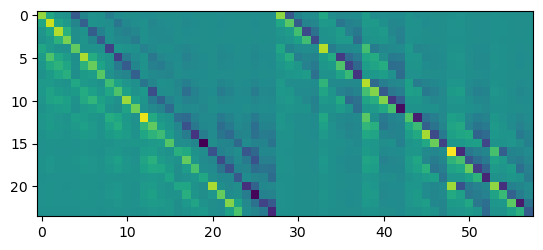

In [ ]:
plt.imshow(Rpinv_mat)
plt.show()